In [1]:
##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 tf.data API 提升性能

In [3]:
%cd ..
from set_env import temp_dir

/media/pc/data/lxw/ai/d2py/doc/libs/tf-chaos/guide


<table class="tfo-notebook-buttons" align="left">
  <td data-parent-segment-id="13650222" data-segment-approved="false"><a target="_blank" href="https://tensorflow.google.cn/guide/data_performance"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td data-parent-segment-id="13650223" data-segment-approved="false"><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/data_performance.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td data-parent-segment-id="13650224" data-segment-approved="false"><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/data_performance.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td data-parent-segment-id="13650225" data-segment-approved="false"><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/data_performance.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

## 概述

GPU 和 TPU 能够极大缩短执行单个训练步骤所需的时间。为了达到最佳性能，需要高效的输入流水线，以在当前步骤完成之前为下一步提供数据。`tf.data` API 有助于构建灵活高效的输入流水线。本文档演示了如何使用 `tf.data` API 构建高性能的 TensorFlow 输入流水线。

继续之前，请阅读“[构建 TensorFlow 输入流水线](https://render.githubusercontent.com/view/data.ipynb)”指南，了解如何使用 `tf.data` API。

## 资源

- [Build TensorFlow input pipelines](./data.ipynb)
- `tf.data.Dataset` API
- [Analyze `tf.data` performance with the TF Profiler](./data_performance_analysis.md)

## 设置

In [4]:
import tensorflow as tf

import time

在本指南中，您将对数据集进行迭代并衡量性能。制定可重现的性能基准可能很困难。影响重现性的不同因素包括：

- 当前的 CPU 负载
- 网络流量
- 缓存等复杂机制

要获得可重现的基准，需要构建人工样本。

### 数据集

定义一个继承自 `tf.data.Dataset` 的类，称为 `ArtificialDataset`。此数据集：

- 生成 `num_samples` 个样本（默认数量为 3）
- 会在第一项模拟打开文件之前休眠一段时间
- 在生成每项之前休眠一段时间，以模拟从文件读取数据

In [5]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )

此数据集类似 `tf.data.Dataset.range`，在开头和每个样本之间添加了固定延迟。

### 训练循环

接下来，编写一个虚拟的训练循环，以测量迭代数据集所用的时间。训练时间是模拟的。

In [6]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    tf.print("Execution time:", time.perf_counter() - start_time)

## 优化性能

为了展示如何优化性能，下面我们将优化 `ArtificialDataset` 的性能。

### 朴素的方法

先从不使用任何技巧的朴素流水线开始，按原样迭代数据集。

In [7]:
benchmark(ArtificialDataset())

Execution time: 0.25911928806453943


从后台可以看到执行时间的花费情况：

![Naive](https://tensorflow.google.cn/guide/images/data_performance/naive.svg)

可以看到，执行一个训练步骤涉及以下操作：

- 打开文件（如果尚未打开）
- 从文件获取数据条目
- 使用数据进行训练

但是，在类似这里的朴素同步实现中，当流水线在获取数据时，模型会处于空闲状态。相反，当模型在进行训练时，输入流水线会处于空闲状态。因此，训练步骤的用时是打开、读取和训练时间的总和。

接下来的各部分将基于此输入流水线，演示设计高效 TensorFlow 输入流水线的最佳做法。

### 预提取

预提取会与训练步骤的预处理和模型执行重叠。在模型执行第 `s` 步训练的同时，输入流水线会读取第 `s+1` 步的数据。这样做能够最大程度减少训练的单步用时（而非总和），并减少提取数据所需的时间。

`tf.data` API 提供了 `tf.data.Dataset.prefetch` 转换。它可以用来将生成数据的时间和使用数据的时间分离。特别是，该转换会使用后台线程和内部缓冲区在请求元素之前从输入数据集中预提取元素。要预提取的元素数量应等于（或可能大于）单个训练步骤使用的批次数。您可以手动调整这个值，或者将其设置为 `tf.data.AUTOTUNE`，这将提示 `tf.data` 运行时在运行期间动态调整该值。

注意，只要有机会将“生产者”的工作和“使用者”的工作重叠，预提取转换就能带来好处。

In [8]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Execution time: 0.245740297017619


![Prefetched](https://tensorflow.google.cn/guide/images/data_performance/prefetched.svg)

这次您可以看到，在针对样本 0 运行训练步骤的同时，输入流水线正在读取样本 1 的数据，依此类推。

### 并行数据提取

在实际设置中，输入数据可能会远程存储（例如，在 Google Cloud Storage 或 HDFS 上）。由于在本地存储空间和远程存储空间之间存在以下差异，在本地读取数据时运行良好的数据集流水线可能会在远程读取数据时成为 I/O 瓶颈：

- **到达第一字节用时**：从远程存储空间中读取文件的第一个字节所花费的时间要比从本地存储空间中读取所花费的时间长几个数量级。
- **读取吞吐量**：虽然远程存储空间通常提供较大的聚合带宽，但读取单个文件可能只能使用此带宽的一小部分。

此外，将原始字节加载到内存中后，可能还需要对数据进行反序列化和/或解密（例如 [protobuf](https://developers.google.com/protocol-buffers/)），这需要进行额外计算。无论数据是本地存储还是远程存储，都会存在此开销，但如果没有高效地预提取数据，在远程情况下会更糟。

为了减轻各种数据提取开销的影响，可以使用 `tf.data.Dataset.interleave` 转换来并行化数据加载步骤，从而交错其他数据集（如数据文件读取器）的内容。可以通过 `cycle_length` 参数指定想要重叠的数据集数量，并通过 `num_parallel_calls` 参数指定并行度级别。与 `prefetch` 转换类似，`interleave` 转换也支持 `tf.data.AUTOTUNE`，它将让 `tf.data` 运行时决定要使用的并行度级别。

#### 顺序交错

`tf.data.Dataset.interleave` 转换的默认参数会使其按顺序交错两个数据集中的单个样本。

In [9]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(ArtificialDataset)
)

Execution time: 0.26613984908908606


![Sequential interleave](https://tensorflow.google.cn/guide/images/data_performance/sequential_interleave.svg)

此数据执行时间图可以展示 `interleave` 转换的行为，从两个可用的数据集中交替提取样本。但是，这里不涉及性能改进。

#### 并行交错

现在，使用 `interleave` 转换的 `num_parallel_calls` 参数。这样可以并行加载多个数据集，从而减少等待打开文件的时间。

In [10]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        ArtificialDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.21591277793049812


![Parallel interleave](https://tensorflow.google.cn/guide/images/data_performance/parallel_interleave.svg)

这次，两个数据集的读取并行进行，从而减少了全局数据处理时间。

### 并行数据转换

准备数据时，可能需要对输入元素进行预处理。为此，`tf.data` API 提供了 `tf.data.Dataset.map` 转换，该转换会将用户定义的函数应用于输入数据集的每个元素。由于输入元素彼此独立，可以在多个 CPU 核心之间并行预处理。为了实现这一点，类似 `prefetch` 和 `interleave` 转换，`map` 转换也提供了`num_parallel_calls` 参数来指定并行度级别。

`num_parallel_calls` 参数最佳值的选择取决于您的硬件、训练数据的特性（如数据大小和形状）、映射函数的开销，以及同一时间在 CPU 上进行的其他处理。一个简单的试探法是使用可用的 CPU 核心数。但是，对于 `prefetch` 和 `interleave` 转换，`map` 转换支持 `tf.data.AUTOTUNE`，它将让 `tf.data` 运行时决定要使用的并行度级别。

In [11]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

#### 顺序映射

首先使用不具有并行度的 `map` 转换作为基准示例。

In [12]:
benchmark(
    ArtificialDataset()
    .map(mapped_function)
)

Execution time: 0.42798346001654863


![Sequential mapping](https://tensorflow.google.cn/guide/images/data_performance/sequential_map.svg)

对于[朴素方法](#The-naive-approach)来说，单次迭代的用时就是花费在打开、读取、预处理（映射）和训练步骤上的时间总和。

#### 并行映射

现在，使用相同的预处理函数，但将其并行应用于多个样本。

In [13]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.32376281288452446


![Parallel mapping](https://tensorflow.google.cn/guide/images/data_performance/parallel_map.svg)

如数据图表所示，预处理步骤重叠，从而减少了单次迭代的总时间。

### 缓存

`tf.data.Dataset.cache` 转换可以在内存中或本地存储空间中缓存数据集。这样可以避免一些运算（如文件打开和数据读取）在每个周期都被执行。

In [14]:
benchmark(
    ArtificialDataset()
    .map(  # Apply time consuming operations before cache
        mapped_function
    ).cache(
    ),
    5
)

Execution time: 0.379621340893209


![Cached dataset](https://tensorflow.google.cn/guide/images/data_performance/cached_dataset.svg)

缓存数据集时，仅在第一个周期执行一次 `cache` 之前的转换（如文件打开和数据读取）。后续周期将重用通过 `cache` 转换缓存的数据。

如果传递到 `map` 转换的用户定义函数开销很大，可在 `map` 转换后应用 `cache` 转换，只要生成的数据集仍然可以放入内存或本地存储空间即可。如果用户定义函数增加了存储数据集所需的空间（超出缓存容量），在 `cache` 转换后应用该函数，或者考虑在训练作业之前对数据进行预处理以减少资源使用。

### 向量化映射

调用传递给 `map` 转换的用户定义函数会产生与调度和执行用户定义函数相关的开销。对用户定义函数进行向量化处理（即，让它一次运算一批输入）并在 `map` 转换*之前*应用 `batch` 转换。

为了说明这种良好做法，不适合使用您的人工数据集。调度延迟大约为 10 微妙（10e-6 秒），远远小于 `ArtificialDataset` 中使用的数十毫秒，因此很难看出它的影响。

在本示例中，我们使用基本 `tf.data.Dataset.range` 函数并将训练循环简化为最简形式。

In [15]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print("Execution time:", time.perf_counter() - start_time)
    
def increment(x):
    return x+1

#### 标量映射

In [16]:
fast_benchmark(
    fast_dataset
    # Apply function one item at a time
    .map(increment)
    # Batch
    .batch(256)
)

Execution time: 0.19943780498579144


![Scalar map](https://tensorflow.google.cn/guide/images/data_performance/scalar_map.svg)

上图说明了正在发生的事情（样本较少）。您可以看到已将映射函数应用于每个样本。虽然此函数速度很快，但会产生一些开销影响时间性能。

#### 向量化映射

In [17]:
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)

Execution time: 0.04210161208175123


![Vectorized map](https://tensorflow.google.cn/guide/images/data_performance/vectorized_map.svg)

这次，映射函数被调用了一次，并被应用于一批样本。如数据执行时间图所示，虽然该函数可能需要花费更多时间执行，但开销仅出现了一次，从而改善了整体时间性能。

### 减少内存占用

许多转换（包括 `interleave`、`prefetch` 和 `shuffle`）会维护元素的内部缓冲区。如果传递给 `map` 转换的用户定义函数更改了元素大小，则映射转换和缓冲元素的转换的顺序会影响内存使用量。通常，我们建议选择能够降低内存占用的顺序，除非需要不同的顺序以提高性能。

#### 缓存部分计算

建议在 `map` 转换后缓存数据集，除非此转换会使数据过大而不适合放在内存中。如果映射函数可以分成两个部分，则能实现折衷：一个耗时的部分和一个消耗内存的部分。在这种情况下，您可以按如下方式将转换链接起来：

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

这样，耗时部分仅在第一个周期执行，从而避免了使用过多缓存空间。

## 最佳做法总结

以下是设计高效 TensorFlow 输入流水线的最佳做法总结：

- [使用 `prefetch` 转换](#Pipelining)使生产者和使用者的工作重叠。
- 使用 `interleave` 转换实现[并行数据读取转换](#Parallelizing-data-extraction)
- 通过设置 `num_parallel_calls` 参数实现[并行 `map` 转换](#Parallelizing-data-transformation)
- 第一个周期[使用 `cache` 转换](#Caching)将数据缓存在内存中。
- [向量化](#Map-and-batch)传递给 `map` 转换的用户定义函数
- 应用 `interleave`、`prefetch` 和 `shuffle` 转换时[减少内存使用量](#Reducing-memory-footprint)

## 重现图表

注：本笔记本的剩余部分是关于如何重现上述图表的，请随意使用以下代码，但请了解其并非本教程的主要内容。

要更深入地了解 `tf.data.Dataset` API，您可以使用自己的流水线。下面是用来绘制本指南中图像的代码。这可以作为一个好的起点，展示了一些常见困难的解决方法，例如：

- 执行时间的可重现性
- 映射函数 Eager Execution
- `interleave` 转换的可调用对象

In [18]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### 数据集

与 `ArtificialDataset` 类似，您可以构建一个返回每步用时的数据集。

In [19]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        
        # Opening the file
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter
            
            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered
            
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

此数据集会提供形状为 `[[2, 1], [2, 2], [2, 3]]` 且类型为 `[tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]` 的样本。每个样本为：

```
(   [("Open"), ("Read")],   [(t0, d), (t0, d)],   [(i, e, -1), (i, e, s)] )
```

其中：

- `Open` 和 `Read` 是步骤标识符
- `t0` 是相应步骤开始时的时间戳
- `d` 是在相应步骤中花费的时间
- `i` 是实例索引
- `e` 是周期索引（数据集被迭代的次数）
- `s` 是样本索引

### 迭代循环

使迭代循环稍微复杂一点，以汇总所有计时。这仅适用于生成上述样本的数据集。

In [20]:
def timelined_benchmark(dataset, num_epochs=2):
    # Initialize accumulators
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # Record dataset preparation informations
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            # Record training informations
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
        
        epoch_elapsed = time.perf_counter() - epoch_enter
        # Record epoch informations
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
    
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

### 绘图方法

最后，定义一个函数，根据 `timelined_benchmark` 函数返回的值绘制时间线。

In [21]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

### 对映射函数使用封装容器

要在 Eager 上下文中运行映射函数，必须将其封装在 `tf.py_function` 调用中。

In [22]:
def map_decorator(func):
    def wrapper(steps, times, values):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

### 流水线对比

In [23]:
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

#### 朴素流水线

In [24]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)  # Time consuming step
    time.sleep(0.0001)  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

Execution time: 14.587872304953635


### 优化后的流水线

In [25]:
@map_decorator
def time_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0])  # Time consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


@map_decorator
def memory_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        dataset_generator_fun,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consuming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consuming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 8.03509536315687


/tmp/ipykernel_4147821/2966908191.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("plasma")


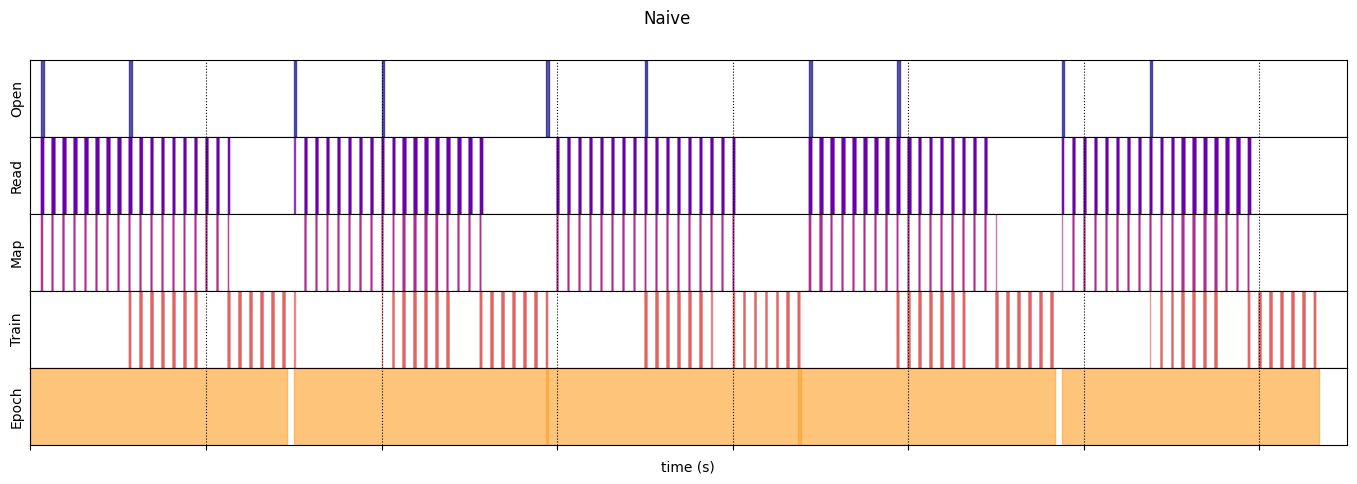

In [26]:
draw_timeline(naive_timeline, "Naive", 15)

/tmp/ipykernel_4147821/2966908191.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("plasma")


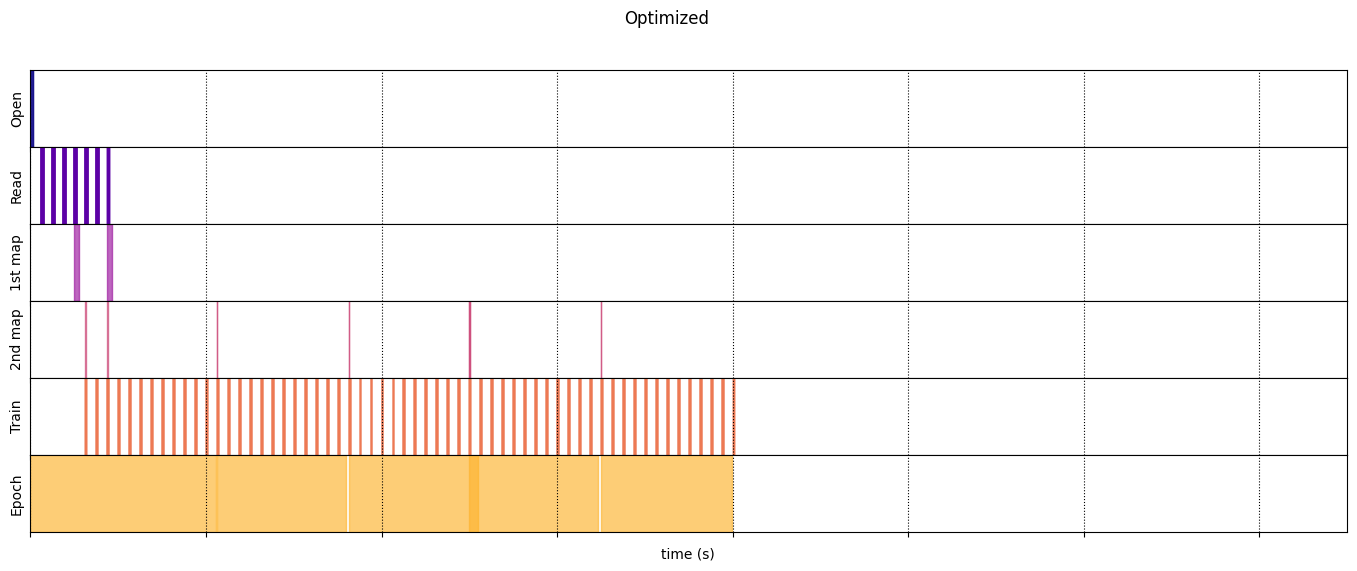

In [27]:
draw_timeline(optimized_timeline, "Optimized", 15)